# SGH - Project

### <i> Using neural network to identify dogs on the pictures</i>


In [ ]:
# Data source
# https://cg.cs.tsinghua.edu.cn/ThuDogs/

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np

import tarfile
import zipfile
import os
import gc

import random
import math

import time
from datetime import timedelta

import PIL.Image
from IPython.display import display
import pickle
import collections

from scipy.stats import itemfreq

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## Adding GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Loading data from the Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file = zipfile.ZipFile("drive/MyDrive/low-resolution.zip", "r") # photos from Tsinghua
#tarfile.open("drive/MyDrive/images.tar") # photos from Stanford

# Data extraction
file.extractall('./')
file.close()

## Training and testing sets

In [5]:
min_breed_images_n = 2000
train_test_split = 0.7

# Splitting data into train and test (photo_id as value, breed_id as key)
train_dict = {}
test_dict = {}

random.seed(123)
for breed in os.listdir("low-resolution"):
  try:
  # All ids for each breed
    current_breed_ids = [os.listdir(f"low-resolution/{breed}")][0]
    if len(current_breed_ids) >= min_breed_images_n:
      # Splitting into train and test
      current_breed_train_ids = random.sample(current_breed_ids, math.floor(train_test_split * len(current_breed_ids)))
      current_breed_test_ids = [image_id for image_id in current_breed_ids if image_id not in current_breed_train_ids]
      #assigning breed and photo_id to the dict
      train_dict[breed] = current_breed_train_ids
      test_dict[breed] = current_breed_test_ids
  except:
    pass

In [6]:
def list_train_test_paths(train_test):
  if train_test == 'train':
    set_dict = train_dict
  elif train_test == 'test':
    set_dict = test_dict

  set_images_paths = []
  for breed_id, breed_images in set_dict.items():
    for image_id in breed_images:
      current_image_path = f'low-resolution/{breed_id}/{image_id}'
      set_images_paths.append(current_image_path)

  return set_images_paths

## Creating pickle file containing data for processed images

In [7]:
def images_to_pickle(train_test, nwidth, nheight):

    set_list = list_train_test_paths(train_test)
    start_time = time.time()
    
    s = (len(set_list), nwidth, nheight, 3)
    allImage = np.zeros(s)
    images_path = []
    i = 0
    for filename in set_list:
      if filename is not None:
        try:
          image = PIL.Image.open(filename)
          image = image.resize((nwidth, nheight))
          image = np.array(image)
          image = np.clip(image/255.0, 0.0, 1.0)
          images_path.append(filename)
          allImage[i]=image
          i += 1
        except:
          pass

    pickle.dump((allImage, images_path), open(train_test + '.pkl', "wb" ) )
    end_time = time.time()
    time_dif = end_time - start_time
    print(f"Total time of the {train_test} set conversion: " + str(timedelta(seconds=int(round(time_dif)))))

In [8]:
# Photos conversion
image_resize = 64

images_to_pickle(train_test = 'train', nwidth = image_resize, nheight = image_resize)
images_to_pickle(train_test = 'test', nwidth = image_resize, nheight = image_resize)

Total time of the train set conversion: 0:02:10
Total time of the test set conversion: 0:01:05


## Loading pickle

In [9]:
# load TRAIN
train_tuple = pickle.load(open( "train.pkl", "rb" ))
train = train_tuple[0]
images_path_train = train_tuple[1]
print(train.shape)

# load TEST
test_tuple = pickle.load(open( "test.pkl", "rb" ))
test = test_tuple[0]
images_path_test = test_tuple[1]
print(test.shape)

(25032, 64, 64, 3)
(10733, 64, 64, 3)


In [10]:
# Cleaning memory
del current_breed_train_ids, current_breed_test_ids, current_breed_ids, train_tuple, test_tuple
gc.collect()

309

## Loading processed images

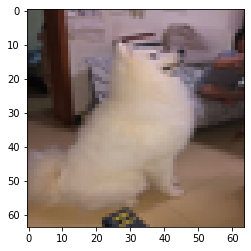

low-resolution/2192-n000088-Samoyed/n124963.jpg


In [11]:
# train set - checking by indexes
i = 1
lum_img = train[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_train[i])

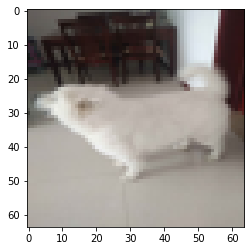

low-resolution/2192-n000088-Samoyed/n125770.jpeg


In [12]:
# Test set - checking by indexes
i = 1
lum_img = test[i,:,:,:]
plt.imshow(lum_img)
plt.show()
print(images_path_test[i])

## Creating charts with the number of photos for each breed

In [13]:
# Creating df with the number of photos of each breed

train_labels = np.array([breed.split('/')[1].split('-')[2] for breed in images_path_train])
test_labels = np.array([breed.split('/')[1].split('-')[2] for breed in images_path_test])

train_count_df = pd.DataFrame.from_dict(collections.Counter(train_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)
test_count_df = pd.DataFrame.from_dict(collections.Counter(test_labels), orient='index', columns=['count']).sort_values(['count'], ascending=False)

In [14]:
fig_breeds_train = px.bar(train_count_df, x='count', y=train_count_df.index, orientation='h', title="Number of photos for each breed - training set")
fig_breeds_train.show()

In [15]:
fig_breeds_test = px.bar(test_count_df, x='count', y=test_count_df.index, orientation='h', title="Number of photos for each breed - testing set")
fig_breeds_test.show()

## Transforming dependent variable

In [16]:
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0],1)

labels_dict = {label:i for i,label in enumerate(np.unique(test_labels))}
print(labels_dict)

def transform_labels(labels, labels_dict):
    labels_output = []
    n_labels = len(labels_dict)
    for i in range(0, len(labels)):
      breed = labels[i][0]
      breed_index = labels_dict[breed]
      labels_output.append([breed_index])
    
    return np.array(labels_output)
  

train_obs_cls = np.array([labels_dict[label[0]] for label in train_labels])
test_obs_cls = np.array([labels_dict[label[0]] for label in test_labels])

train_labels_bin = transform_labels(train_labels, labels_dict)
test_labels_bin = transform_labels(test_labels, labels_dict)
print(train_labels_bin.shape)
print(test_labels_bin.shape)

{'Bichon_Frise': 0, 'Border_collie': 1, 'Cardigan': 2, 'Labrador_retriever': 3, 'Samoyed': 4, 'chinese_rural_dog': 5, 'golden_retriever': 6, 'miniature_schnauzer': 7, 'teddy': 8, 'toy_poodle': 9}
(25032, 1)
(10733, 1)


## Creating a structure of CNN

In [17]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(4,4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(4,4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0

## CNN training

In [18]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', 
                          patience=3,
                          verbose=1)

history = model.fit(train, train_labels_bin, epochs=100, callbacks = [early_stop],
                      validation_data=(test, test_labels_bin))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



783/783 [==============================] - 23s 15ms/step - loss: 1.9641 - accuracy: 0.2913 - val_loss: 1.7928 - val_accuracy: 0.3688
Epoch 2/100
783/783 [==============================] - 12s 16ms/step - loss: 1.7563 - accuracy: 0.3774 - val_loss: 1.7601 - val_accuracy: 0.3851
Epoch 3/100
783/783 [==============================] - 11s 14ms/step - loss: 1.6572 - accuracy: 0.4145 - val_loss: 1.5477 - val_accuracy: 0.4553
Epoch 4/100
783/783 [==============================] - 12s 15ms/step - loss: 1.5658 - accuracy: 0.4507 - val_loss: 1.5114 - val_accuracy: 0.4700
Epoch 5/100
783/783 [==============================] - 11s 14ms/step - loss: 1.5008 - accuracy: 0.4735 - val_loss: 1.4469 - val_accuracy: 0.4970
Epoch 6/100
783/783 [==============================] - 11s 14ms/step - loss: 1.4496 - accuracy: 0.4925 - val_loss: 1.4148 - val_accuracy: 0.5144
Epoch 7/100
783/783 [==============================] - 12s 15ms/step - loss: 1.4010 - accuracy: 0.5065 - val_loss: 1.3870 - val_accuracy: 0.52

In [19]:
metrics_df = pd.DataFrame(history.history)
metrics_df.tail()

,loss,accuracy,val_loss,val_accuracy
17,1.104732,0.608261,1.309804,0.558092
18,1.073730,0.619807,1.289031,0.564893
19,1.054339,0.624361,1.316740,0.552502
20,1.055290,0.622443,1.289411,0.567316
21,1.018361,0.633869,1.317687,0.557440


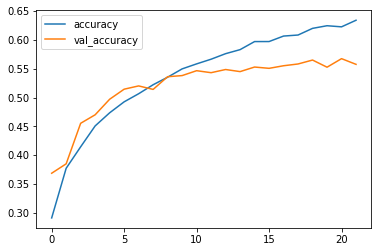

In [20]:
metrics_df[["accuracy","val_accuracy"]].plot()

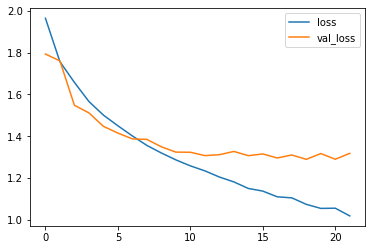

In [21]:
metrics_df[["loss","val_loss"]].plot()

# Confusion matrix

In [23]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 15
    
    fig, axes = plt.subplots(5, 3, figsize=(14,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='binary')
        xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def plot_confusion_matrix(data_obs_cls, data_predicted_cls, labels_dict):

    cm = confusion_matrix(y_true=data_obs_cls,
                          y_pred=data_predicted_cls)
    print(cm)
    plt.matshow(cm, cmap='coolwarm')

    plt.colorbar()
    num_classes = len(labels_dict)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.show()

    return np.asmatrix(cm)

## Forecasting

In [22]:
# Forecast
test_obs_cls = np.array([labels_dict[label[0]] for label in test_labels])
test_pred_cls = np.array([np.argmax(pred) for pred in model.predict(test)])

{'Bichon_Frise': 0, 'Border_collie': 1, 'Cardigan': 2, 'Labrador_retriever': 3, 'Samoyed': 4, 'chinese_rural_dog': 5, 'golden_retriever': 6, 'miniature_schnauzer': 7, 'teddy': 8, 'toy_poodle': 9}


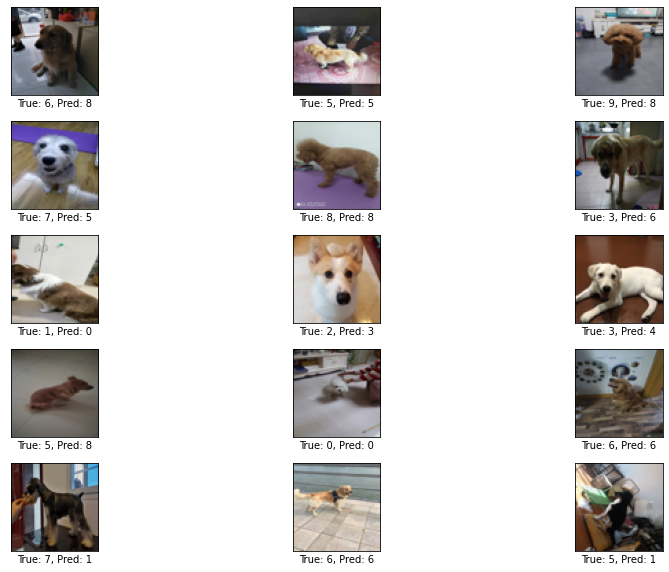

In [24]:
indices = random.sample(range(0, len(test_labels)), 15)

print(labels_dict)
plot_images(images=test[indices], cls_true=list(map(test_obs_cls.__getitem__, indices)), cls_pred=list(map(test_pred_cls.__getitem__, indices)))

[[ 667    0    0   34  117   25    7    6   68    1]
 [   9  484   45   51   24   76   16   41   33    0]
 [   9   40  494   41   22   86  120   22   39    0]
 [  68    8   11  534  111   62  141   34  105    0]
 [ 131    7    5   58  396   28   16    7   10    0]
 [  81   48   55  150   72  243  189   58  105    0]
 [  22    2   15  150   25   55 1075    3  256    4]
 [  33   24    7   91   13   72   20  357   86    0]
 [ 147    7    4   99   26   63  108   55 1714   12]
 [ 119    3    5   60   28   22   52   33  537   19]]


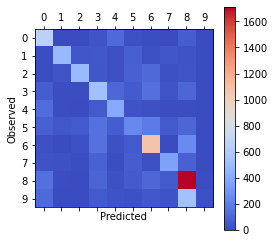

In [27]:
confusion_matrix = plot_confusion_matrix(test_obs_cls, test_pred_cls, labels_dict)

In [1]:
limit = 200
labels_indices_dict = {value:key for key,value in labels_dict.items()}
indices_matrix = np.asmatrix(np.where(confusion_matrix > limit))
misclassified_breeds = []
for i in range(0, indices_matrix.shape[1]):
  breed_1 = labels_indices_dict[indices_matrix[:,i][0].item()]
  breed_2 = labels_indices_dict[indices_matrix[:,i][1].item()]
  breed_tuple = (breed_1, breed_2)
  breed_tuple_rev = (breed_2, breed_1)
  if breed_1 != breed_2 and breed_tuple_rev not in misclassified_breeds:
    misclassified_breeds.append(breed_tuple)

print(f'Breeds with the biggest nr of mistakes (>{limit}): \n')
misclassified_breeds

NameError: name 'labels_dict' is not defined

# Calculating accuracy for each breed

In [29]:
breed_accuracy_df = pd.DataFrame({'observed_class':test_obs_cls, 'predicted_class':test_pred_cls})
breed_accuracy_df['breed_name'] = breed_accuracy_df['observed_class'].map(lambda i: labels_indices_dict[i])
breed_accuracy_df['accurate_pred'] = np.where(breed_accuracy_df['predicted_class']==breed_accuracy_df['observed_class'], 1, 0)

breed_accuracy_df = breed_accuracy_df[['breed_name', 'accurate_pred']].groupby('breed_name') \
                        .mean().sort_values(by='accurate_pred', ascending=False).reset_index()
breed_accuracy_df

,breed_name,accurate_pred
0,teddy,0.766890
1,Bichon_Frise,0.721081
2,golden_retriever,0.668948
3,Border_collie,0.621309
4,Samoyed,0.601824
5,Cardigan,0.565865
6,miniature_schnauzer,0.507824
7,Labrador_retriever,0.497207
8,chinese_rural_dog,0.242757
9,toy_poodle,0.021640


In [30]:
fig_accuracy_test = px.bar(breed_accuracy_df, x='accurate_pred', y=breed_accuracy_df['breed_name'], orientation='h', title="Accuracy for each breed")
fig_accuracy_test.show()

# Saving model

In [33]:
model.save("model.h5")

# Loading model
load_saved_model = tf.keras.models.load_model("model.h5")